Esse notebook é uma tradução do [artigo](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-three-388834e8804b) originalmente escrito por [William Koehrsen](https://twitter.com/koehrsen_will) no site [Towards Data Science](https://towardsdatascience.com)

# Um projeto completo de aprendizado de máquina em Python - Parte 3

Os modelos de aprendizado de máquina são frequentemente criticados como [caixas-pretas](https://datascience.stackexchange.com/questions/22335/why-are-machine-learning-models-called-black-boxes): colocamos os dados de um lado e recebemos as respostas - geralmente respostas muito precisas - sem explicações do outro. Na terceira parte desta série, que mostra uma solução completa de aprendizado de máquina, veremos o modelo que desenvolvemos para tentar entender como ele faz previsões e o que pode nos ensinar sobre o problema. Vamos encerrar discutindo talvez a parte mais importante de um projeto de aprendizado de máquina: documentar nosso trabalho e apresentar resultados.

A [primeira parte](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20One.ipynb) da série cobriu a limpeza de dados, a análise exploratória de dados, a engenharia de features e a seleção de features. A [parte dois](https://github.com/willsilvano/datascience/blob/master/Towards%20DataScience/Energy%20New%20York%20-%20Part%20Two.ipynb) cobriu a imputação de valores ausentes, implementação e comparação de modelos de aprendizado de máquina, ajuste de hiperparâmetros usando pesquisa aleatória com validação cruzada e avaliando um modelo.

Relembrando, estamos trabalhando em um problema de aprendizado de máquina de regressão supervisionada. Usando os [dados de energia de edifícios de Nova York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml), desenvolvemos um modelo que pode prever a pontuação Energy Star de um edifício. O modelo final que construímos é um [Gradient Boosted Regressor](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), que é capaz de prever o Energy Star Score nos dados de teste com um erro de 8.5 pontos (em uma escala de 1 a 100).


# Bibliotecas

Usaremos um conjunto familiar de bibliotecas de ciência de dados e aprendizado de máquina.

In [1]:
# Pandas e Numpy para manipulação de dados
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib para visualização
import matplotlib.pyplot as plt
%matplotlib inline

# Altera o tamanho padrão da fonte
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn para visualização
import seaborn as sns

sns.set(font_scale = 2)

# Imputação de valores faltantes
from sklearn.preprocessing import Imputer, MinMaxScaler

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME para explicar as predições
import lime 
import lime.lime_tabular

# Leitura dos dados armazenados anteriormente

In [2]:
train_features = pd.read_csv('data/energy_new_york_training_features.csv')
test_features = pd.read_csv('data/energy_new_york_testing_features.csv')
train_labels = pd.read_csv('data/energy_new_york_training_labels.csv')
test_labels = pd.read_csv('data/energy_new_york_testing_labels.csv')

# Recriar o modelo final

In [3]:
# Criar um imputer com a estratégia de preenchimento pela mediana
imputer = Imputer(strategy='median')

# Treina o imputer com o conjunto de treinamento
imputer.fit(train_features)

# Transforma os dados de treino e teste
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Transformar os valores de saida para vetor unidimensional
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Função para calcular o erro médio absoluto MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [6]:
# Realiza as predições no conjunto de teste
model_pred = model.predict(X_test)

print('Performance do Modelo Final no conjunto de teste: MAE = %0.4f' % mae(y_test, model_pred))

Performance do Modelo Final no conjunto de teste: MAE = 9.0837


# Interpretação do Modelo

O gradient boosted regressor está em algum lugar no meio da [escala de interpretabilidade do modelo](https://2.bp.blogspot.com/-AL1LsaTHVNQ/Wh589GDwkaI/AAAAAAAAaxc/nwpqKEUIgXokRxt75nzgzQz00IRqH68PACLcBGAs/s1600/B2G1g0UIMAEieiR.png): o modelo inteiro é complexo, mas é composto de centenas de [árvores de decisão](https://en.wikipedia.org/wiki/Decision_tree_learning), que por si só são bastante compreensíveis. Vamos ver três maneiras de entender como nosso modelo faz previsões:

1. [Importâncias das features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
2. Visualizando uma única árvore de decisão
3. [LIME: Explicações de modelo agnóstico local interpretável](https://github.com/marcotcr/lime)

Os dois primeiros métodos são específicos para conjuntos de árvores, enquanto o terceiro - como você pode ter adivinhado pelo nome - pode ser aplicado a qualquer modelo de aprendizado de máquina. O LIME é um pacote relativamente novo e representa um passo empolgante no esforço contínuo para [explicar as previsões de aprendizado de máquina](https://pdfs.semanticscholar.org/ab4a/92795ee236632e6dbbe9338ae99778b57e1e.pdf).


# Importâncias das features

As importâncias de features tentam mostrar a relevância de cada feature para a tarefa de prever o destino (score). Os detalhes técnicos das importâncias de features são complexos (eles medem a [impureza média de redução](https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf) ou a [redução no erro na inclusão de feature](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)), mas podemos usar os valores relativos para comparar quais features são as mais relevantes. No Scikit-Learn, podemos [extrair as importâncias de features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) de qualquer grupo de aprendizes baseados em árvore.

Com o `model` como nosso modelo treinado, podemos encontrar as importâncias das features usando `model.feature_importances_`. Em seguida, podemos colocá-los em um DataFrame pandas e exibir ou plotar os dez primeiros mais importantes:

In [7]:
# Extraimos as importâncias das features e inserimos em um dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns),
                                'importance': model.feature_importances_})

# Mostra o top 10 das features mais importantes no modelo
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.403532
1,Weather Normalized Site Electricity Intensity ...,0.263059
2,Water Intensity (All Water Sources) (gal/ft²),0.071286
3,Property Id,0.035165
4,Largest Property Use Type_Non-Refrigerated War...,0.031924
5,DOF Gross Floor Area,0.027900
6,log_Water Intensity (All Water Sources) (gal/ft²),0.026058
7,Order,0.024592
8,log_Direct GHG Emissions (Metric Tons CO2e),0.023655
9,Year Built,0.022100


As variáveis `Site EUI` e `Weather Normalized Site Electricity Intensity` são as duas características mais importantes por uma margem bastante grande. Depois disso, a importância relativa cai consideravelmente, o que indica que talvez não seja necessário manter todas as features para criar um modelo com quase o mesmo desempenho.

Vamos plotar as importâncias para ficar mais claro e podermos comparar visualmente.

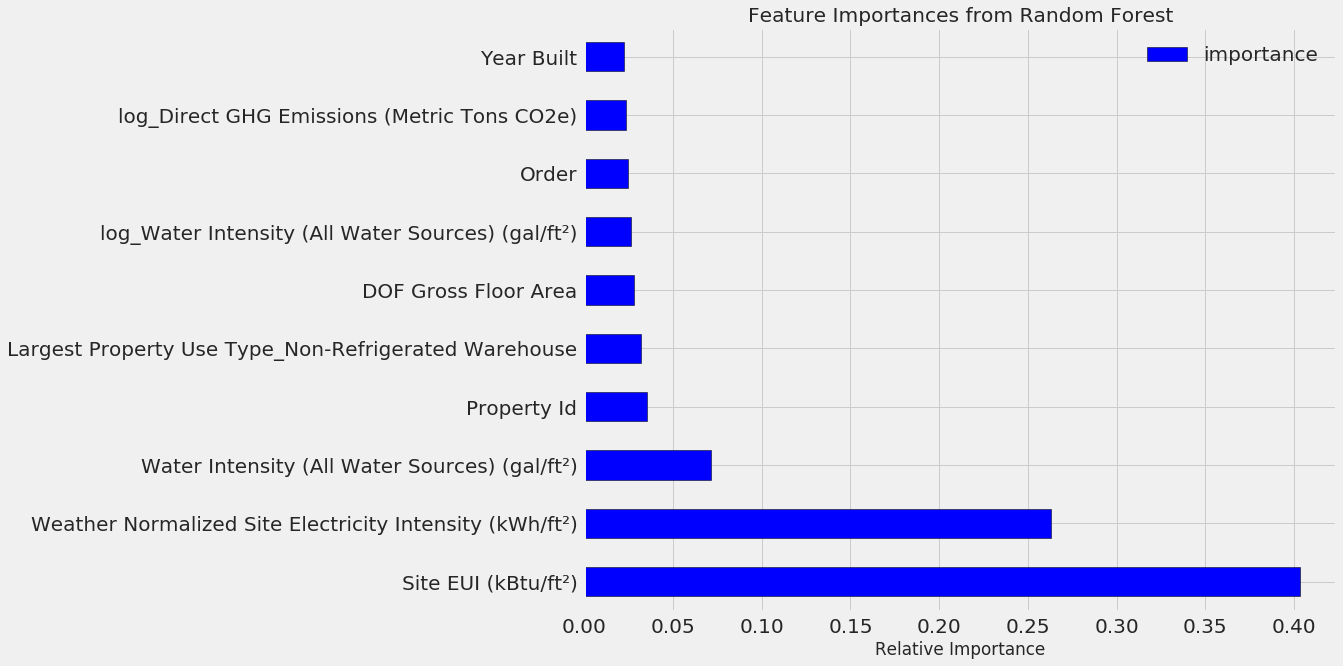

In [8]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x='feature', y='importance',
                                edgecolor='k',
                                kind='barh', color='blue')

plt.xlabel('Relative Importance')
plt.ylabel('')
plt.title('Feature Importances from Random Forest')
plt.show()

Com base nesses resultados, podemos finalmente responder a uma de nossas perguntas iniciais: os indicadores mais importantes do Energy Star Score de um edifício são Site EUI e Weather Normalized Site Electricity Intensity. Embora desejemos ter [cuidado ao ler demais as importâncias de recursos](http://parrt.cs.usfca.edu/doc/rf-importance/index.html), elas são uma maneira útil de começar a entender como o modelo faz suas previsões.

# Usando Importâncias de Features para Seleção de Features

Dado que nem todas as features são importantes para encontrar a pontuação, o que aconteceria se usássemos um modelo mais simples, como uma regressão linear, com o subconjunto de features mais importantes da floresta aleatória? A regressão linear superou a linha de base, mas não teve um bom desempenho em comparação com os modelos complexos do modelo. Vamos tentar usar apenas os 10 features mais importantes da regressão linear para ver se o desempenho é melhorado. Também podemos limitar essas features e reavaliar a floresta aleatória.

In [9]:
# Extraimos os nomes das features mais importantes
most_important_features = feature_results['feature'][:10]

# Procuramos os indices correspondentes a cada uma das features de acordo com o nome
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Mantemos apenas as features mais importantes
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Dimensões do conjunto de treino com as features mais importantes:', X_reduced.shape)
print('Dimensões do conjunto de teste com as features mais importantes:', X_test_reduced.shape)

Dimensões do conjunto de treino com as features mais importantes: (6622, 10)
Dimensões do conjunto de teste com as features mais importantes: (2839, 10)


In [10]:
# Cria o modelo de regressão linear
lr = LinearRegression()

# Treina e realiza predição com todas features 
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Treina e realiza predição com as top 10 features mais importantes
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

print('Desempenho do modelo Regressão Linear com todas as features: MAE = %0.4f' % mae(y_test, lr_full_pred))
print('Desempenho do modelo Regressão Linear com top 10 features: MAE = %0.4f' % mae(y_test, lr_reduced_pred))

Desempenho do modelo Regressão Linear com todas as features: MAE = 13.4651
Desempenho do modelo Regressão Linear com top 10 features: MAE = 15.1007


Bem, reduzindo os recursos não melhorou os resultados da regressão linear! Acontece que as informações extras nas features de baixa importância realmente melhoram o desempenho.

Vamos examinar o uso do conjunto reduzido de features no gradient boosted regressor. Como o desempenho é afetado?

In [11]:
# Criar o modelo com os mesmos hiperparâmetros
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Treina e testa com as top 10 features mais importantes
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Desempenho do modelo GradientBoostingRegressor com top 10 features: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Desempenho do modelo GradientBoostingRegressor com top 10 features: MAE = 10.8594


Os resultados do modelo são um pouco piores com o conjunto reduzido de features e manteremos todas as features para o modelo final. O desejo de reduzir o número de features é porque estamos sempre procurando construir o [modelo mais parcimonioso](http://www.statisticshowto.com/parsimonious-model/): ou seja, o modelo mais simples com desempenho adequado. Um modelo que usa menos features será mais rápido de treinar e geralmente mais fácil de interpretar. Nesse caso, manter todas as features não é uma grande preocupação, porque o tempo de treinamento não é significativo e ainda podemos fazer interpretações com muitas features.

# Visualizando uma árvore de decisão única

Embora todo o gradient boosting regressor possa ser difícil de entender, qualquer árvore de decisão individual é bastante intuitiva. Podemos visualizar qualquer árvore na floresta usando a [função Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) `export_graphviz`. Primeiro, extraímos uma árvore do conjunto e a salvamos como um arquivo de ponto:


In [12]:
# Extrair uma única árvore (número 105)
single_tree = model_reduced.estimators_[105][0]

# Salva a árvore num arquivo ".dot"
tree.export_graphviz(single_tree, out_file='images/tree.dot', 
                     rounded=True, feature_names=most_important_features)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=6,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x7f449b92a9d8>,
           splitter='best')

In [13]:
# Convert to a png from the command line
# This requires the graphviz visualization library (https://www.graphviz.org/)
!dot -Tpng images/tree.dot -o images/tree.png

<img src="images/tree.png">

Essa é uma árvore inteira no nosso regressor de 800! É um pouco difícil de entender porque a profundidade máxima da árvore é 5. Para melhorar a legibilidade, podemos limitar a profundidade máxima na chamada para exportar nossa árvore.

In [14]:
tree.export_graphviz(single_tree, out_file='images/tree_small.dot',
                    rounded=True, filled=True, max_depth=3,
                    feature_names = most_important_features)
!dot -Tpng images/tree_small.dot -o images/tree_small.png

<img src="images/tree_small.png">

Agora podemos dar uma olhada na árvore e tentar intrepretar suas decisões! A melhor maneira de pensar em uma árvore de decisão é como uma série de perguntas sim / não, como um fluxograma. Começamos no topo, chamamos a raiz, e seguimos nosso caminho pela árvore, com a direção da viagem determinada pela resposta de cada equação.

Por exemplo, aqui a primeira pergunta que fazemos é: o Site EUI é menor ou igual a 15,95? Se a resposta for sim, então nos movemos para a esquerda e fazemos a pergunta: o Weather Normalized Site Electricity Intensity é menor ou igual a 3,85? Se a resposta à primeira pergunta foi não, nós nos movemos para a direita e perguntamos se a Weather Normalized Site Electricity Intensity é menor ou igual a 26,85?

Continuamos esse processo iterativo até alcançarmos a parte inferior da árvore e terminamos em um nó de folha. Aqui, o valor que predizemos corresponde ao valor mostrado no nó (os valores nessa árvore parecem ser as previsões reais divididas por 100).

Cada nó (caixa) na árvore possui quatro partes de informação:

1. A pergunta feita sobre o valor de uma feature: isso determina se vamos descer para o próximo nó da direita ou da esquerda.
2. `mse` que é uma medida do erro do nó
3. `samples` que é o número de exemplos no nó
4. `value` é a estimativa do alvo para todas as amostras no nó

![](https://cdn-images-1.medium.com/max/800/1*e-GLVi1Ss6pjDPh6l8UFCQ.png)

Podemos ver que à medida que aumentamos a profundidade da árvore, poderemos ajustar melhor os dados. Com uma árvore pequena, haverá muitos exemplos em cada nó folha e, como o modelo estima o mesmo valor para cada exemplo em um nó, provavelmente haverá um erro maior (a menos que todos os exemplos tenham o mesmo valor de destino). Construir uma árvore grande demais pode levar ao overfitting. Podemos controlar um número de hiperparâmetros que determinam a profundidade da árvore e o número de exemplos em cada folha. Vimos como selecionar alguns desses hyperaparameters na segunda parte quando realizamos a otimização usando a validação cruzada.

Embora claramente não possamos examinar todas as árvores em nosso modelo, olhar para uma única nos dá uma ideia de como nosso modelo faz previsões. Na verdade, esse método baseado em fluxograma parece muito com o modo como um ser humano toma decisões, respondendo a uma pergunta sobre um único valor por vez. Conjuntos baseados em árvore de decisão simplesmente tomam a idéia de uma única árvore de decisão e combinam as previsões de muitos indivíduos para criar um modelo com menos variância que um único estimador. Conjuntos de árvores tendem a ser muito precisos, e também são intuitivos para explicar!

# Explicação Agnóstico do Modelo Interpretável Local (LIME)

A ferramenta final que exploraremos para tentar entender como nosso modelo “pensa” é uma nova entrada no campo das explicações do modelo. A [LIME visa explicar uma única previsão de qualquer modelo de aprendizado de máquina](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime), criando uma aproximação do modelo localmente próximo ao ponto de dados, usando um modelo simples, como a regressão linear (os [detalhes completos podem ser encontrados no artigo](https://arxiv.org/pdf/1602.04938.pdf)).

Aqui vamos usar o LIME para examinar uma previsão que o modelo faz completamente errado para ver o que ele pode nos dizer sobre por que o modelo comete erros.

Primeiro precisamos encontrar a observação de que nosso modelo está mais errado. Fazemos isso treinando e prevendo com o modelo e extraindo o exemplo no qual o modelo tem o maior erro. Nós nos restringiremos a usar o conjunto reduzido de 10 features para ajudar a interpretabilidade. O modelo treinado nas 10 features mais importantes é um pouco menos preciso, mas geralmente temos que compensar a precisão pela interpretabilidade!

In [15]:
# Procura pelos resíduos
residuals = abs(model_reduced_pred - y_test)

# Extrai a pior e a melhor predição
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Values: %0.4f' % y_test[np.argmax(residuals)])

Prediction: 12.8615
Actual Values: 100.0000


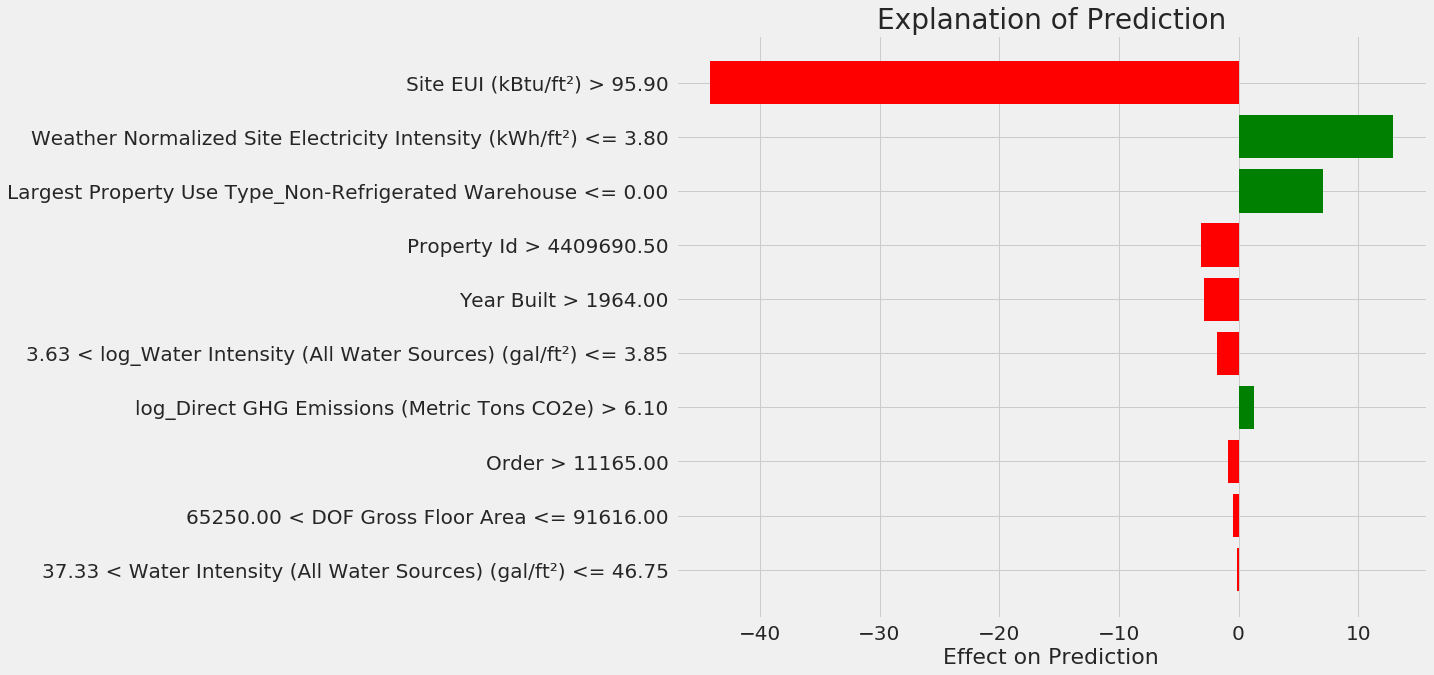

In [20]:
# Cria um lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_reduced,
                                                   mode='regression',
                                                   training_labels=y,
                                                   feature_names=list(most_important_features))

# Explicação para a pior predição
wrong_exp = explainer.explain_instance(data_row=wrong,
                                       predict_fn=model_reduced.predict)

wrong_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size=28)
plt.xlabel('Effect on Prediction', size=22)
plt.show()

Veja como interpretar o gráfico: cada entrada no eixo y indica um valor de uma variável e as barras vermelha e verde mostram o efeito que esse valor tem na previsão. Por exemplo, a entrada superior diz que o Site EUI é maior que 95,90, o que subtrai cerca de 40 pontos da previsão. A segunda entrada diz que a Weather Normalized Site Electricity Intensity é menor que 3.80, o que adiciona cerca de 10 pontos à previsão. A previsão final é um termo de interceptação mais a soma de cada uma dessas contribuições individuais.

Podemos dar outra olhada nas mesmas informações chamando o método `explainer.show_in_notebook`:

In [23]:
wrong_exp.show_in_notebook(show_predicted_value=False)

Isso mostra o processo de raciocínio do modelo à esquerda, exibindo as contribuições de cada variável para a previsão. A tabela à direita mostra os valores atuais das variáveis.

Para este exemplo, a previsão do modelo foi de cerca de 12 e o valor real foi de 100! Embora inicialmente essa previsão possa ser intrigante, olhando para a explicação, podemos ver que isso não foi um palpite extremo, mas uma estimativa razoável, dados os valores. O Site EUI era relativamente alto e esperávamos que o Energy Star Score fosse baixo (porque o EUI está fortemente correlacionado negativamente com o score), uma conclusão compartilhada pelo nosso modelo. Nesse caso, a lógica estava com defeito porque o prédio tinha uma pontuação perfeita de 100.

Pode ser frustrante quando um modelo está errado, mas explicações como essas nos ajudam a entender por que o modelo está incorreto. Além disso, com base na explicação, poderíamos querer investigar por que o edifício tem uma pontuação perfeita, apesar de um Site EUI tão alto. Talvez possamos aprender algo novo sobre o problema que teria nos escapado sem investigar o modelo. Ferramentas como essa não são perfeitas, mas nos ajudam muito a entender o modelo que, por sua vez, pode nos permitir tomar [melhores decisões](https://www.youtube.com/watch?v=hnSgIUA57hg).




# Documentando o Trabalho e Reportando Resultados

Uma parte frequentemente negligenciada de qualquer projeto técnico é a documentação e o relatório. Podemos fazer a melhor análise do mundo, mas se não [comunicarmos claramente os resultados](http://blog.kaggle.com/2016/06/29/communicating-data-science-a-guide-to-presenting-your-work/), eles não terão impacto algum!

Quando documentamos um projeto de ciência de dados, pegamos todas as versões dos dados e do código e as empacotamos para que o nosso projeto possa ser reproduzido ou construído por outros cientistas de dados. É importante lembrar que o código é lido com mais frequência do que está escrito e queremos garantir que nosso trabalho seja compreensível **tanto para os outros quanto para nós mesmos**, se voltarmos a ele alguns meses depois. Isso significa colocar comentários úteis no código e explicar seu raciocínio. Acho que os [Jupyter Notebooks](http://jupyter.org/) são uma ótima ferramenta para documentação porque permitem explicações e código um após o outro.

Os Jupyter Notebooks também podem ser uma boa plataforma para comunicar descobertas a outras pessoas. Usando [extensões do notebook](https://github.com/ipython-contrib/jupyter_contrib_nbextensions), podemos [ocultar o código de nosso relatório final](https://github.com/kirbs-/hide_code) porque, embora seja difícil de acreditar, nem todo mundo quer ver um monte de código Python em um documento!

Pessoalmente, luto resumindo sucintamente o meu trabalho porque gosto de passar por todos os detalhes. o entanto, é importante [entender seu público-alvo](http://sites.ieee.org/pcs/communication-resources-for-engineers/audience-purpose-and-context/understand-your-audience/) quando você apresenta e [adapta a mensagem de acordo](https://hbr.org/2015/04/the-best-presentations-are-tailored-to-the-audience). Com isso em mente, eis a minha conclusão de 30 segundos do projeto:

1. Usando os dados de energia da cidade de Nova York, é possível construir um modelo que possa prever a pontuação Energy Star dos edifícios em 9,1 pontos.


2. O Site EUI e a Weather Normalized Electricity Intensity são os fatores mais relevantes para a previsão do Energy Star Score.

Originalmente, recebi este projeto como uma "tarefa" de triagem de trabalho por uma startup. Para o relatório final, eles queriam ver meu trabalho e minhas conclusões, então desenvolvi um Jupyter Notebook para entregar. No entanto, em vez de converter diretamente para PDF no Jupyter, eu o converti em um arquivo [Latex](https://www.latex-project.org/) `.tex` que eu editei no [texStudio](https://www.texstudio.org/) antes de renderizar para um PDF para a [versão final](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Building%20Data%20Report.pdf). A conversão para PDF do Jupyter tem uma aparência decente, mas pode ser significativamente melhorada com alguns minutos de edição. Além disso, o Latex é um poderoso sistema de preparação de documentos e é bom conhecer o básico.

No final do dia, nosso trabalho é tão valioso quanto as decisões que ele permite, e ser capaz de apresentar resultados é uma habilidade crucial. Além disso, ao documentarmos o trabalho adequadamente, permitimos que outros reproduzam nossos resultados, nos forneçam feedback para que possamos nos tornar melhores cientistas de dados e desenvolver nosso trabalho para o futuro.

# Conclusões

Em toda essa série de postagens, passamos por um projeto completo de aprendizado de máquina de ponta a ponta. Começamos limpando os dados, mudamos para a construção de modelos e finalmente analisamos como interpretar um modelo de aprendizado de máquina. Como lembrete, a estrutura geral de um projeto de aprendizado de máquina está abaixo:

1. Limpeza de dados e formatação
2. Análise exploratória de dados
3. Engenharia e seleção de features
4. Compare vários modelos de aprendizado de máquina em uma métrica de desempenho
5. Execute o ajuste de hiperparâmetros no melhor modelo
6. Avaliar o melhor modelo no conjunto de testes
7. Interpretar os resultados do modelo
8. Tire conclusões e escreva um relatório bem documentado

Embora as etapas exatas variem por projeto, e o aprendizado de máquina geralmente é um [processo iterativo em vez de linear](https://en.wikipedia.org/wiki/Iteration), esse guia deve atendê-lo bem ao abordar futuros projetos de aprendizado de máquina. Espero que esta série tenha lhe dado confiança para poder implementar suas próprias soluções de aprendizado de máquina, mas lembre-se, **nenhum de nós faz isso por nós mesmos**! Se você quiser alguma ajuda, há muitas comunidades incrivelmente apoiadoras onde você pode procurar por conselhos.

Alguns recursos que achei úteis em todo o meu processo de aprendizado:

- [Hands-On Machine Learning with Scikit-Learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do) ([Jupyter Notebooks para este livro](https://github.com/ageron/handson-ml) estão disponíveis online gratuitamente)!

- [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)

- [Kaggle: The Home of Data Science and Machine Learning](https://www.kaggle.com/)

- [Datacamp](https://www.datacamp.com/): Bons tutoriais para principiantes para praticar a codificação da ciência de dados

- [Coursera](https://www.coursera.org/): Cursos gratuitos e pagos em muitas disciplinas

- [Udacity](https://www.udacity.com/): cursos de programação e ciência de dados pagos
